# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
! rm ./data/celeba.zip

rm: cannot remove './data/celeba.zip': No such file or directory


In [5]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [6]:
alpha = 0.15

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

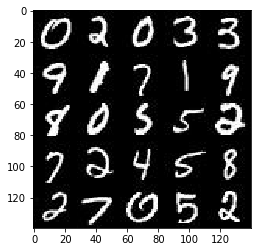

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

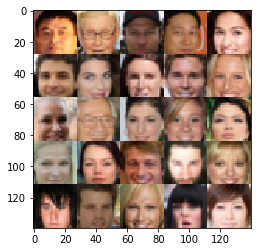

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_z')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    return img, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
#     print('discriminator')
#     print('images: ', images)
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is ?x28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(0.02 * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=0.5)
        # 14x14x64
#         print(x1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.02 * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.5)
        # 7x7x128
#         print(x2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.02 * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.5)
        # 4x4x256 
#         print(x3)
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
#         print(logits)
        out = tf.sigmoid(logits)
#         print('discriminator out: ', out)
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
#     print('generator')
#     print('out_channel_dim: ', out_channel_dim)
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
#         x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
#         print(x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
#         print(x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
#         print(x3)

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
#         print(logits)3
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
#     print('Generator for fake images...')
    g_model = generator(input_z, out_channel_dim)
#     print('Passing discriminator with real images...')
    d_model_real, d_logits_real = discriminator(input_real)
#     print('Passing discriminator with fake images...')
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1, global_step):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars, 
                                                                              global_step=global_step)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars, 
                                                                                  global_step=global_step)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# tests.test_model_opt(model_opt, tf)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Utility functions for training."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


from tensorflow.python.eager import context
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import graph_io
from tensorflow.python.framework import ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import resource_variable_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.ops import variables
from tensorflow.python.platform import tf_logging as logging


# Picked a long key value to minimize the chance of collision with user defined
# collection keys.
GLOBAL_STEP_READ_KEY = 'global_step_read_op_cache'


# TODO(drpng): remove this after legacy uses are resolved.
write_graph = graph_io.write_graph


def global_step(sess, global_step_tensor):
  """Small helper to get the global step.

  ```python
  # Creates a variable to hold the global_step.
  global_step_tensor = tf.Variable(10, trainable=False, name='global_step')
  # Creates a session.
  sess = tf.Session()
  # Initializes the variable.
  print('global_step: %s' % tf.train.global_step(sess, global_step_tensor))

  global_step: 10
  ```

  Args:
    sess: A TensorFlow `Session` object.
    global_step_tensor:  `Tensor` or the `name` of the operation that contains
      the global step.

  Returns:
    The global step value.
  """
  if context.in_eager_mode():
    return int(global_step_tensor.numpy())
  return int(sess.run(global_step_tensor))


def get_global_step(graph=None):
  """Get the global step tensor.

  The global step tensor must be an integer variable. We first try to find it
  in the collection `GLOBAL_STEP`, or by name `global_step:0`.

  Args:
    graph: The graph to find the global step in. If missing, use default graph.

  Returns:
    The global step variable, or `None` if none was found.

  Raises:
    TypeError: If the global step tensor has a non-integer type, or if it is not
      a `Variable`.
  """
  graph = graph or ops.get_default_graph()
  global_step_tensor = None
  global_step_tensors = graph.get_collection(ops.GraphKeys.GLOBAL_STEP)
  if len(global_step_tensors) == 1:
    global_step_tensor = global_step_tensors[0]
  elif not global_step_tensors:
    try:
      global_step_tensor = graph.get_tensor_by_name('global_step:0')
    except KeyError:
      return None
  else:
    logging.error('Multiple tensors in global_step collection.')
    return None

  assert_global_step(global_step_tensor)
  return global_step_tensor


def create_global_step(graph=None):
  """Create global step tensor in graph.

  Args:
    graph: The graph in which to create the global step tensor. If missing,
      use default graph.

  Returns:
    Global step tensor.

  Raises:
    ValueError: if global step tensor is already defined.
  """
  graph = graph or ops.get_default_graph()
  if get_global_step(graph) is not None:
    raise ValueError('"global_step" already exists.')
  # Create in proper graph and base name_scope.
  with graph.as_default() as g, g.name_scope(None):
    return variable_scope.get_variable(
        ops.GraphKeys.GLOBAL_STEP,
        shape=[],
        dtype=dtypes.int64,
        initializer=init_ops.zeros_initializer(),
        trainable=False,
        collections=[ops.GraphKeys.GLOBAL_VARIABLES, ops.GraphKeys.GLOBAL_STEP])


def get_or_create_global_step(graph=None):
  """Returns and create (if necessary) the global step tensor.

  Args:
    graph: The graph in which to create the global step tensor. If missing, use
      default graph.

  Returns:
    The global step tensor.
  """
  graph = graph or ops.get_default_graph()
  global_step_tensor = get_global_step(graph)
  if global_step_tensor is None:
    global_step_tensor = create_global_step(graph)
  return global_step_tensor


def assert_global_step(global_step_tensor):
  """Asserts `global_step_tensor` is a scalar int `Variable` or `Tensor`.

  Args:
    global_step_tensor: `Tensor` to test.
  """
  if not (isinstance(global_step_tensor, variables.Variable) or
          isinstance(global_step_tensor, ops.Tensor) or
          isinstance(global_step_tensor,
                     resource_variable_ops.ResourceVariable)):
    raise TypeError(
        'Existing "global_step" must be a Variable or Tensor: %s.' %
        global_step_tensor)

  if not global_step_tensor.dtype.base_dtype.is_integer:
    raise TypeError('Existing "global_step" does not have integer type: %s' %
                    global_step_tensor.dtype)

  if (global_step_tensor.get_shape().ndims != 0 and
      global_step_tensor.get_shape().is_fully_defined()):
    raise TypeError('Existing "global_step" is not scalar: %s' %
                    global_step_tensor.get_shape())


def _get_global_step_read(graph=None):
  """Gets global step read tensor in graph.

  Args:
    graph: The graph in which to create the global step read tensor. If missing,
      use default graph.

  Returns:
    Global step read tensor.

  Raises:
    RuntimeError: if multiple items found in collection GLOBAL_STEP_READ_KEY.
  """
  graph = graph or ops.get_default_graph()
  global_step_read_tensors = graph.get_collection(GLOBAL_STEP_READ_KEY)
  if len(global_step_read_tensors) > 1:
    raise RuntimeError('There are multiple items in collection {}. '
                       'There should be only one.'.format(GLOBAL_STEP_READ_KEY))

  if len(global_step_read_tensors) == 1:
    return global_step_read_tensors[0]
  return None


def _get_or_create_global_step_read(graph=None):
  """Gets or creates global step read tensor in graph.

  Args:
    graph: The graph in which to create the global step read tensor. If missing,
      use default graph.

  Returns:
    Global step read tensor if there is global_step_tensor else return None.
  """
  graph = graph or ops.get_default_graph()
  global_step_read_tensor = _get_global_step_read(graph)
  if global_step_read_tensor is not None:
    return global_step_read_tensor
  global_step_tensor = get_global_step(graph)
  if global_step_tensor is None:
    return None
  # add 'zero' so that it will create a copy of variable as Tensor.
  with graph.as_default() as g, g.name_scope(None):
    # using initialized_value to ensure that global_step is initialized before
    # this run. This is needed for example Estimator makes all model_fn build
    # under global_step_read_tensor dependency.
    global_step_value = global_step_tensor.initialized_value() if isinstance(
        global_step_tensor, variables.Variable) else global_step_tensor
    global_step_read_tensor = global_step_value + 0
    ops.add_to_collection(GLOBAL_STEP_READ_KEY, global_step_read_tensor)
  return _get_global_step_read(graph)


def _increment_global_step(increment, graph=None):
  graph = graph or ops.get_default_graph()
  global_step_tensor = get_global_step(graph)
  if global_step_tensor is None:
    raise ValueError(
        'Global step tensor should be created by '
        'tf.train.get_or_create_global_step before calling increment.')
  global_step_read_tensor = _get_or_create_global_step_read(graph)
  with graph.as_default() as g, g.name_scope(None):
    with ops.control_dependencies([global_step_read_tensor]):
      return state_ops.assign_add(global_step_tensor, increment)

In [52]:
# tf.reset_default_graph()
show_every=20
print_every=1

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print(epoch_count)
    print(batch_size)
    print(z_dim)
    print(learning_rate)
    print(beta1)
    print(data_shape)
    print(data_image_mode)
    
    
    global_step = get_or_create_global_step()
    global_step_inc = global_step.assign_add(1)
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1, global_step)
    
    print(d_train_opt)
    print(g_train_opt)
    

    
    steps = 0
    print('Starting Session...')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('Epoch :', epoch_i)
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                batch_images = batch_images*2.0
                
                batch_z = np.ones([batch_size, z_dim])
                for i in range(batch_size):
                    batch_z[i] = np.random.uniform(-1, 1, size=(z_dim))
                
                _, gstep = sess.run([global_step_inc, global_step])
                _ = sess.run([d_train_opt, g_train_opt], feed_dict={input_real: batch_images, input_z: batch_z})
#                 _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                
                if steps % print_every == 0:
                    print("steps: {}".format(steps))
                    print("Global step: {}".format(gstep))
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

In [53]:
batch_size = 3
z_dim = 5
batch_z = np.ones([batch_size, z_dim])
print(np.random.uniform(-1, 1, size=(z_dim)))
batch_z

[ 0.80692225 -0.48404248  0.88086171 -0.67102654 -0.49219462]


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [54]:
batch_z = np.ones([batch_size, z_dim])
for i in range(batch_size):
    batch_z[i] = np.random.uniform(-1, 1, size=(z_dim))
    
batch_z

array([[ 0.07901459,  0.48672566, -0.24747657,  0.89548529, -0.90460037],
       [-0.85283512,  0.2373628 ,  0.82012356,  0.31044435,  0.19767709],
       [ 0.19800258, -0.5531155 , -0.94631442,  0.64360716, -0.5514394 ]])

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2
64
30
0.001
0.4
(60000, 28, 28, 1)
L
name: "Adam"
op: "AssignAdd"
input: "global_step"
input: "Adam/value"
attr {
  key: "T"
  value {
    type: DT_INT64
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@global_step"
    }
  }
}
attr {
  key: "use_locking"
  value {
    b: false
  }
}

name: "Adam_1"
op: "AssignAdd"
input: "global_step"
input: "Adam_1/value"
attr {
  key: "T"
  value {
    type: DT_INT64
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@global_step"
    }
  }
}
attr {
  key: "use_locking"
  value {
    b: false
  }
}

Starting Session...
Epoch : 0
steps: 1
Global step: 1
Epoch 1/2... Discriminator Loss: 5.9856... Generator Loss: 0.0038
steps: 2
Global step: 4
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 17.8217
steps: 3
Global step: 7
Epoch 1/2... Discriminator Loss: 2.4724... Generator Loss: 0.1583
steps: 4
Global step: 10
Epoch 1/2... Discriminator Loss: 7.5394... Generator Loss: 19.0240
steps: 5
Global step: 13
Epoch 1/2

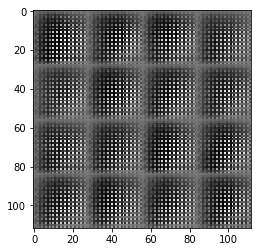

steps: 21
Global step: 61
Epoch 1/2... Discriminator Loss: 0.0189... Generator Loss: 13.9165
steps: 22
Global step: 64
Epoch 1/2... Discriminator Loss: 0.0699... Generator Loss: 11.5677
steps: 23
Global step: 67
Epoch 1/2... Discriminator Loss: 0.0150... Generator Loss: 8.9978
steps: 24
Global step: 70
Epoch 1/2... Discriminator Loss: 0.0239... Generator Loss: 6.1473
steps: 25
Global step: 73
Epoch 1/2... Discriminator Loss: 0.0174... Generator Loss: 4.8544
steps: 26
Global step: 76
Epoch 1/2... Discriminator Loss: 0.0393... Generator Loss: 4.3774
steps: 27
Global step: 79
Epoch 1/2... Discriminator Loss: 0.0258... Generator Loss: 4.7980
steps: 28
Global step: 82
Epoch 1/2... Discriminator Loss: 0.0184... Generator Loss: 5.3167
steps: 29
Global step: 85
Epoch 1/2... Discriminator Loss: 0.0357... Generator Loss: 5.4557
steps: 30
Global step: 88
Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 5.7606
steps: 31
Global step: 91
Epoch 1/2... Discriminator Loss: 0.0101... Generator

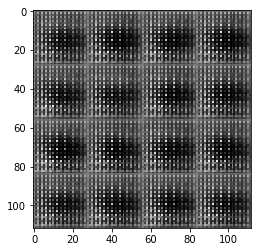

steps: 41
Global step: 121
Epoch 1/2... Discriminator Loss: 0.0114... Generator Loss: 5.9299
steps: 42
Global step: 124
Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 5.9938
steps: 43
Global step: 127
Epoch 1/2... Discriminator Loss: 0.0087... Generator Loss: 6.0891
steps: 44
Global step: 130
Epoch 1/2... Discriminator Loss: 0.0041... Generator Loss: 6.1765
steps: 45
Global step: 133
Epoch 1/2... Discriminator Loss: 0.0337... Generator Loss: 3.5345
steps: 46
Global step: 136
Epoch 1/2... Discriminator Loss: 0.0610... Generator Loss: 2.8923
steps: 47
Global step: 139
Epoch 1/2... Discriminator Loss: 0.0369... Generator Loss: 3.5312
steps: 48
Global step: 142
Epoch 1/2... Discriminator Loss: 2.8389... Generator Loss: 0.1411
steps: 49
Global step: 145
Epoch 1/2... Discriminator Loss: 6.6994... Generator Loss: 25.4187
steps: 50
Global step: 148
Epoch 1/2... Discriminator Loss: 2.1597... Generator Loss: 1.8943
steps: 51
Global step: 151
Epoch 1/2... Discriminator Loss: 1.3666...

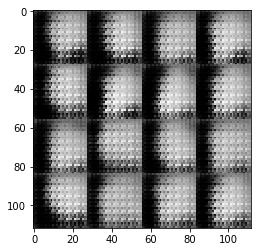

steps: 61
Global step: 181
Epoch 1/2... Discriminator Loss: 0.2239... Generator Loss: 4.2065
steps: 62
Global step: 184
Epoch 1/2... Discriminator Loss: 0.2063... Generator Loss: 2.7389
steps: 63
Global step: 187
Epoch 1/2... Discriminator Loss: 1.5524... Generator Loss: 0.3329
steps: 64
Global step: 190
Epoch 1/2... Discriminator Loss: 3.0417... Generator Loss: 3.4576
steps: 65
Global step: 193
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 0.8372
steps: 66
Global step: 196
Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 14.8941
steps: 67
Global step: 199
Epoch 1/2... Discriminator Loss: 0.3008... Generator Loss: 11.0891
steps: 68
Global step: 202
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 1.4102
steps: 69
Global step: 205
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 3.0542
steps: 70
Global step: 208
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 0.8450
steps: 71
Global step: 211
Epoch 1/2... Discriminator Loss: 0.6107..

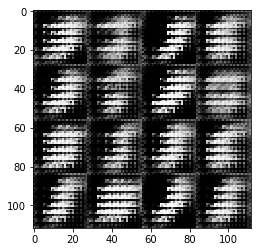

steps: 81
Global step: 241
Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 1.7340
steps: 82
Global step: 244
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 2.9889
steps: 83
Global step: 247
Epoch 1/2... Discriminator Loss: 2.2170... Generator Loss: 0.2326
steps: 84
Global step: 250
Epoch 1/2... Discriminator Loss: 3.4766... Generator Loss: 9.2374
steps: 85
Global step: 253
Epoch 1/2... Discriminator Loss: 1.7083... Generator Loss: 1.0858
steps: 86
Global step: 256
Epoch 1/2... Discriminator Loss: 1.8380... Generator Loss: 0.3936
steps: 87
Global step: 259
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 2.7194
steps: 88
Global step: 262
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 1.0334
steps: 89
Global step: 265
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.8347
steps: 90
Global step: 268
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 5.4724
steps: 91
Global step: 271
Epoch 1/2... Discriminator Loss: 0.8410... 

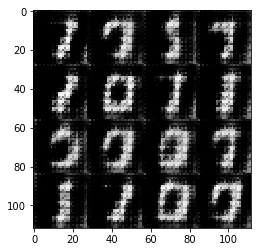

steps: 101
Global step: 301
Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 2.9366
steps: 102
Global step: 304
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.7058
steps: 103
Global step: 307
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.1021
steps: 104
Global step: 310
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 1.6073
steps: 105
Global step: 313
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.4657
steps: 106
Global step: 316
Epoch 1/2... Discriminator Loss: 1.6476... Generator Loss: 4.0671
steps: 107
Global step: 319
Epoch 1/2... Discriminator Loss: 1.8504... Generator Loss: 0.2411
steps: 108
Global step: 322
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 4.1289
steps: 109
Global step: 325
Epoch 1/2... Discriminator Loss: 1.5623... Generator Loss: 0.4621
steps: 110
Global step: 328
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 1.8195
steps: 111
Global step: 331
Epoch 1/2... Discriminator Loss:

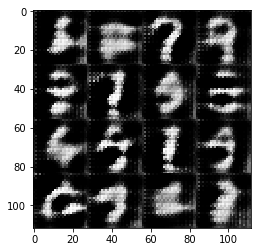

steps: 121
Global step: 361
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 2.1487
steps: 122
Global step: 364
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.4501
steps: 123
Global step: 367
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 2.3808
steps: 124
Global step: 370
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.8150
steps: 125
Global step: 373
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 1.4300
steps: 126
Global step: 376
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.5199
steps: 127
Global step: 379
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 0.9995
steps: 128
Global step: 382
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 1.3433
steps: 129
Global step: 385
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 1.0454
steps: 130
Global step: 388
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.6061
steps: 131
Global step: 391
Epoch 1/2... Discriminator Loss:

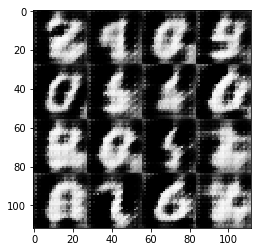

steps: 141
Global step: 421
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.4577
steps: 142
Global step: 424
Epoch 1/2... Discriminator Loss: 0.9848... Generator Loss: 2.8577
steps: 143
Global step: 427
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.4045
steps: 144
Global step: 430
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 2.4975
steps: 145
Global step: 433
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 0.8539
steps: 146
Global step: 436
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.6588
steps: 147
Global step: 439
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 0.6911
steps: 148
Global step: 442
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 2.1810
steps: 149
Global step: 445
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.3644
steps: 150
Global step: 448
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 3.1663
steps: 151
Global step: 451
Epoch 1/2... Discriminator Loss:

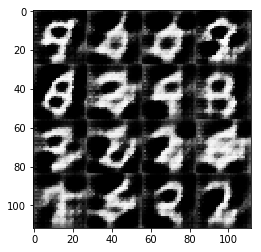

steps: 161
Global step: 481
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.8661
steps: 162
Global step: 484
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 0.6999
steps: 163
Global step: 487
Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 1.4940
steps: 164
Global step: 490
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.5984
steps: 165
Global step: 493
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 1.6233
steps: 166
Global step: 496
Epoch 1/2... Discriminator Loss: 1.7833... Generator Loss: 0.2678
steps: 167
Global step: 499
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 3.9427
steps: 168
Global step: 502
Epoch 1/2... Discriminator Loss: 1.5589... Generator Loss: 0.3772
steps: 169
Global step: 505
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 2.8817
steps: 170
Global step: 508
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.7210
steps: 171
Global step: 511
Epoch 1/2... Discriminator Loss:

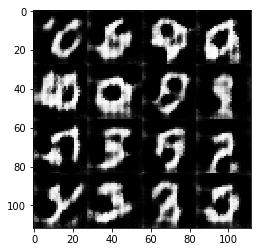

steps: 181
Global step: 541
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 2.0232
steps: 182
Global step: 544
Epoch 1/2... Discriminator Loss: 2.2105... Generator Loss: 0.1906
steps: 183
Global step: 547
Epoch 1/2... Discriminator Loss: 2.0595... Generator Loss: 3.8837
steps: 184
Global step: 550
Epoch 1/2... Discriminator Loss: 2.0600... Generator Loss: 0.2195
steps: 185
Global step: 553
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 1.5197
steps: 186
Global step: 556
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.7537
steps: 187
Global step: 559
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 1.1670
steps: 188
Global step: 562
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8526
steps: 189
Global step: 565
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.9752
steps: 190
Global step: 568
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.1860
steps: 191
Global step: 571
Epoch 1/2... Discriminator Loss:

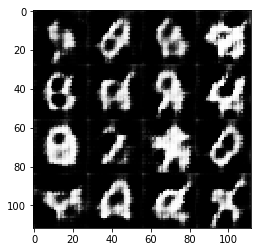

steps: 201
Global step: 601
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.1765
steps: 202
Global step: 604
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.1416
steps: 203
Global step: 607
Epoch 1/2... Discriminator Loss: 0.8108... Generator Loss: 1.1122
steps: 204
Global step: 610
Epoch 1/2... Discriminator Loss: 0.7757... Generator Loss: 1.3369
steps: 205
Global step: 613
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 0.7587
steps: 206
Global step: 616
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 1.5840
steps: 207
Global step: 619
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 0.6275
steps: 208
Global step: 622
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.6770
steps: 209
Global step: 625
Epoch 1/2... Discriminator Loss: 2.2845... Generator Loss: 0.1558
steps: 210
Global step: 628
Epoch 1/2... Discriminator Loss: 2.0454... Generator Loss: 3.1060
steps: 211
Global step: 631
Epoch 1/2... Discriminator Loss:

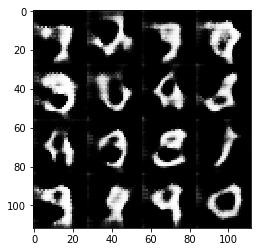

steps: 221
Global step: 661
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.5774
steps: 222
Global step: 664
Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 1.5300
steps: 223
Global step: 667
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 0.7624
steps: 224
Global step: 670
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 1.2502
steps: 225
Global step: 673
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.4953
steps: 226
Global step: 676
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 1.9532
steps: 227
Global step: 679
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.4660
steps: 228
Global step: 682
Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 1.3763
steps: 229
Global step: 685
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8915
steps: 230
Global step: 688
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.1154
steps: 231
Global step: 691
Epoch 1/2... Discriminator Loss:

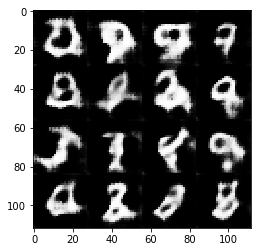

steps: 241
Global step: 721
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.6786
steps: 242
Global step: 724
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.7845
steps: 243
Global step: 727
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.3774
steps: 244
Global step: 730
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.7492
steps: 245
Global step: 733
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 1.0190
steps: 246
Global step: 736
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.9296
steps: 247
Global step: 739
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.7989
steps: 248
Global step: 742
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 1.0452
steps: 249
Global step: 745
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.5510
steps: 250
Global step: 748
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 1.6437
steps: 251
Global step: 751
Epoch 1/2... Discriminator Loss:

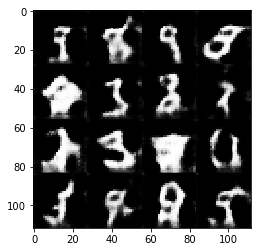

steps: 261
Global step: 781
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 1.6987
steps: 262
Global step: 784
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.5447
steps: 263
Global step: 787
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.8709
steps: 264
Global step: 790
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.5707
steps: 265
Global step: 793
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.5781
steps: 266
Global step: 796
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.6355
steps: 267
Global step: 799
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.0099
steps: 268
Global step: 802
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.8227
steps: 269
Global step: 805
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.7358
steps: 270
Global step: 808
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.9686
steps: 271
Global step: 811
Epoch 1/2... Discriminator Loss:

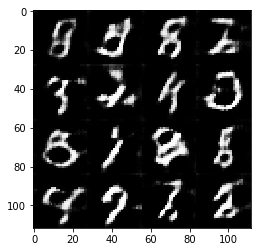

steps: 281
Global step: 841
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.7186
steps: 282
Global step: 844
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.6327
steps: 283
Global step: 847
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.7478
steps: 284
Global step: 850
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 1.4595
steps: 285
Global step: 853
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 0.6212
steps: 286
Global step: 856
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 1.4700
steps: 287
Global step: 859
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 0.7783
steps: 288
Global step: 862
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 0.6469
steps: 289
Global step: 865
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 1.1576
steps: 290
Global step: 868
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.9925
steps: 291
Global step: 871
Epoch 1/2... Discriminator Loss:

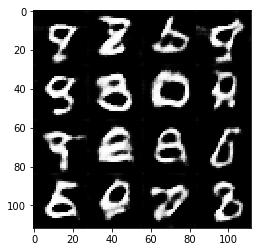

steps: 301
Global step: 901
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.7954
steps: 302
Global step: 904
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 1.5056
steps: 303
Global step: 907
Epoch 1/2... Discriminator Loss: 1.9738... Generator Loss: 0.2559
steps: 304
Global step: 910
Epoch 1/2... Discriminator Loss: 1.7886... Generator Loss: 3.1694
steps: 305
Global step: 913
Epoch 1/2... Discriminator Loss: 1.5245... Generator Loss: 0.4166
steps: 306
Global step: 916
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 1.0470
steps: 307
Global step: 919
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.8614
steps: 308
Global step: 922
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.6255
steps: 309
Global step: 925
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 1.1312
steps: 310
Global step: 928
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 0.6432
steps: 311
Global step: 931
Epoch 1/2... Discriminator Loss:

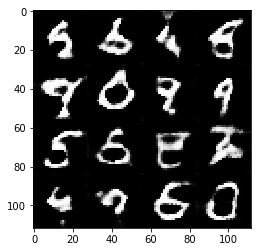

steps: 321
Global step: 961
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 1.1458
steps: 322
Global step: 964
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.8464
steps: 323
Global step: 967
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.4745
steps: 324
Global step: 970
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.4550
steps: 325
Global step: 973
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 1.9243
steps: 326
Global step: 976
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.3549
steps: 327
Global step: 979
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 2.0553
steps: 328
Global step: 982
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.5509
steps: 329
Global step: 985
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.0583
steps: 330
Global step: 988
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 1.0637
steps: 331
Global step: 991
Epoch 1/2... Discriminator Loss:

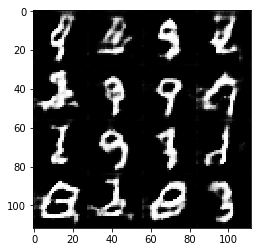

steps: 341
Global step: 1021
Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.9615
steps: 342
Global step: 1024
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.5851
steps: 343
Global step: 1027
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.1961
steps: 344
Global step: 1030
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 0.9203
steps: 345
Global step: 1033
Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 0.9921
steps: 346
Global step: 1036
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.9980
steps: 347
Global step: 1039
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 0.8205
steps: 348
Global step: 1042
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 1.1790
steps: 349
Global step: 1045
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.7375
steps: 350
Global step: 1048
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 2.1834
steps: 351
Global step: 1051
Epoch 1/2... Discrimi

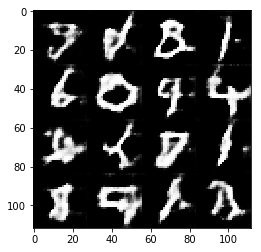

steps: 361
Global step: 1081
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.8616
steps: 362
Global step: 1084
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.2158
steps: 363
Global step: 1087
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.7214
steps: 364
Global step: 1090
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 1.2448
steps: 365
Global step: 1093
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.5642
steps: 366
Global step: 1096
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 1.8280
steps: 367
Global step: 1099
Epoch 1/2... Discriminator Loss: 1.6486... Generator Loss: 0.3046
steps: 368
Global step: 1102
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 2.1626
steps: 369
Global step: 1105
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.3325
steps: 370
Global step: 1108
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 1.2890
steps: 371
Global step: 1111
Epoch 1/2... Discrimi

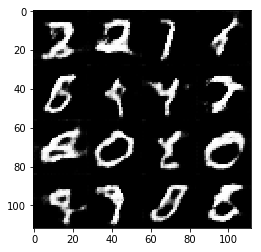

steps: 381
Global step: 1141
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.2555
steps: 382
Global step: 1144
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.8847
steps: 383
Global step: 1147
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.9030
steps: 384
Global step: 1150
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.0476
steps: 385
Global step: 1153
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.9850
steps: 386
Global step: 1156
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.5619
steps: 387
Global step: 1159
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 1.3583
steps: 388
Global step: 1162
Epoch 1/2... Discriminator Loss: 1.6771... Generator Loss: 0.3817
steps: 389
Global step: 1165
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 2.3579
steps: 390
Global step: 1168
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.6359
steps: 391
Global step: 1171
Epoch 1/2... Discrimi

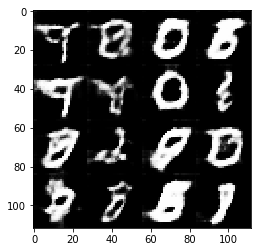

steps: 401
Global step: 1201
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 0.7984
steps: 402
Global step: 1204
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 1.0127
steps: 403
Global step: 1207
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.7882
steps: 404
Global step: 1210
Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 1.1020
steps: 405
Global step: 1213
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.5618
steps: 406
Global step: 1216
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 2.0316
steps: 407
Global step: 1219
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 0.3588
steps: 408
Global step: 1222
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 1.9369
steps: 409
Global step: 1225
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.4515
steps: 410
Global step: 1228
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.6360
steps: 411
Global step: 1231
Epoch 1/2... Discrimi

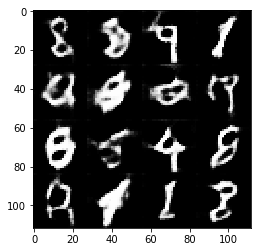

steps: 421
Global step: 1261
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.4176
steps: 422
Global step: 1264
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 2.0380
steps: 423
Global step: 1267
Epoch 1/2... Discriminator Loss: 1.7904... Generator Loss: 0.2899
steps: 424
Global step: 1270
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 2.2666
steps: 425
Global step: 1273
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.5266
steps: 426
Global step: 1276
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 1.4213
steps: 427
Global step: 1279
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.8596
steps: 428
Global step: 1282
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.6545
steps: 429
Global step: 1285
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.2587
steps: 430
Global step: 1288
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.3698
steps: 431
Global step: 1291
Epoch 1/2... Discrimi

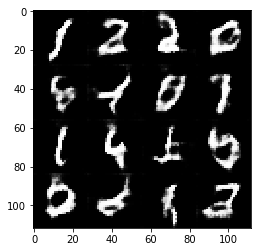

steps: 441
Global step: 1321
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.8204
steps: 442
Global step: 1324
Epoch 1/2... Discriminator Loss: 1.5642... Generator Loss: 0.3534
steps: 443
Global step: 1327
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 2.2333
steps: 444
Global step: 1330
Epoch 1/2... Discriminator Loss: 1.5929... Generator Loss: 0.3277
steps: 445
Global step: 1333
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 1.5939
steps: 446
Global step: 1336
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.6864
steps: 447
Global step: 1339
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.9097
steps: 448
Global step: 1342
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.2885
steps: 449
Global step: 1345
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 0.8182
steps: 450
Global step: 1348
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.9743
steps: 451
Global step: 1351
Epoch 1/2... Discrimi

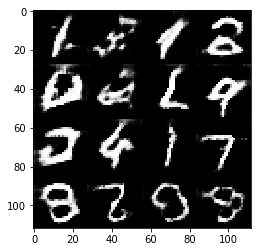

steps: 461
Global step: 1381
Epoch 1/2... Discriminator Loss: 1.1184... Generator Loss: 0.9351
steps: 462
Global step: 1384
Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 1.0220
steps: 463
Global step: 1387
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.6371
steps: 464
Global step: 1390
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 1.3883
steps: 465
Global step: 1393
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.5431
steps: 466
Global step: 1396
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 1.1890
steps: 467
Global step: 1399
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 0.8559
steps: 468
Global step: 1402
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 1.4760
steps: 469
Global step: 1405
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.6166
steps: 470
Global step: 1408
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 1.2045
steps: 471
Global step: 1411
Epoch 1/2... Discrimi

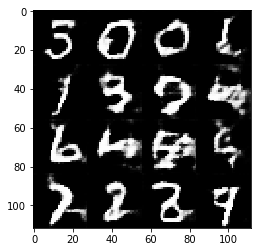

steps: 481
Global step: 1441
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 1.2478
steps: 482
Global step: 1444
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 1.0762
steps: 483
Global step: 1447
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.4411
steps: 484
Global step: 1450
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.9274
steps: 485
Global step: 1453
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.6269
steps: 486
Global step: 1456
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 1.6082
steps: 487
Global step: 1459
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.4682
steps: 488
Global step: 1462
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 1.9921
steps: 489
Global step: 1465
Epoch 1/2... Discriminator Loss: 1.7875... Generator Loss: 0.2949
steps: 490
Global step: 1468
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 2.0351
steps: 491
Global step: 1471
Epoch 1/2... Discrimi

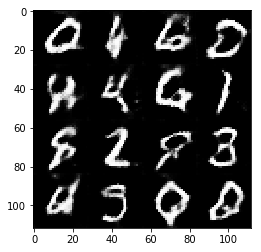

steps: 501
Global step: 1501
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.2127
steps: 502
Global step: 1504
Epoch 1/2... Discriminator Loss: 1.1054... Generator Loss: 0.8118
steps: 503
Global step: 1507
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.8888
steps: 504
Global step: 1510
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.9964
steps: 505
Global step: 1513
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.8135
steps: 506
Global step: 1516
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 1.0362
steps: 507
Global step: 1519
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.6919
steps: 508
Global step: 1522
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.4027
steps: 509
Global step: 1525
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.5881
steps: 510
Global step: 1528
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.3498
steps: 511
Global step: 1531
Epoch 1/2... Discrimi

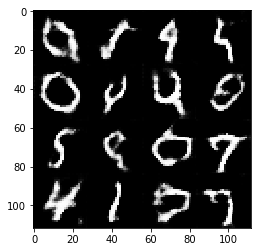

steps: 521
Global step: 1561
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.5407
steps: 522
Global step: 1564
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.3827
steps: 523
Global step: 1567
Epoch 1/2... Discriminator Loss: 1.0928... Generator Loss: 1.7145
steps: 524
Global step: 1570
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.5424
steps: 525
Global step: 1573
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 1.4657
steps: 526
Global step: 1576
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.4265
steps: 527
Global step: 1579
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 2.0254
steps: 528
Global step: 1582
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.3808
steps: 529
Global step: 1585
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 2.3647
steps: 530
Global step: 1588
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 0.6140
steps: 531
Global step: 1591
Epoch 1/2... Discrimi

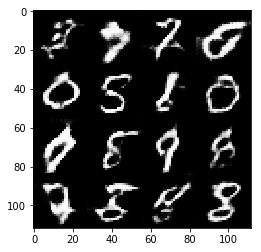

steps: 541
Global step: 1621
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.1051
steps: 542
Global step: 1624
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.7926
steps: 543
Global step: 1627
Epoch 1/2... Discriminator Loss: 0.8838... Generator Loss: 1.2204
steps: 544
Global step: 1630
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.7054
steps: 545
Global step: 1633
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.2174
steps: 546
Global step: 1636
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 0.5228
steps: 547
Global step: 1639
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 2.5283
steps: 548
Global step: 1642
Epoch 1/2... Discriminator Loss: 2.0345... Generator Loss: 0.2062
steps: 549
Global step: 1645
Epoch 1/2... Discriminator Loss: 1.6242... Generator Loss: 2.7983
steps: 550
Global step: 1648
Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 0.4236
steps: 551
Global step: 1651
Epoch 1/2... Discrimi

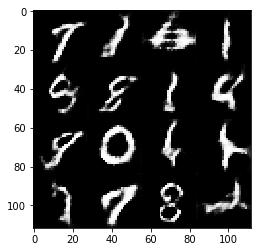

steps: 561
Global step: 1681
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.3797
steps: 562
Global step: 1684
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.5480
steps: 563
Global step: 1687
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 1.4722
steps: 564
Global step: 1690
Epoch 1/2... Discriminator Loss: 1.5038... Generator Loss: 0.3483
steps: 565
Global step: 1693
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 2.1085
steps: 566
Global step: 1696
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 0.6745
steps: 567
Global step: 1699
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 1.4841
steps: 568
Global step: 1702
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 0.4684
steps: 569
Global step: 1705
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.7269
steps: 570
Global step: 1708
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.5340
steps: 571
Global step: 1711
Epoch 1/2... Discrimi

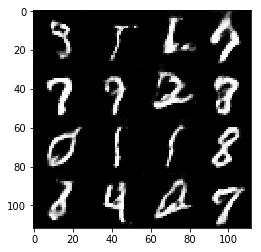

steps: 581
Global step: 1741
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.9254
steps: 582
Global step: 1744
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.4058
steps: 583
Global step: 1747
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.5365
steps: 584
Global step: 1750
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.5091
steps: 585
Global step: 1753
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 1.3501
steps: 586
Global step: 1756
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.6598
steps: 587
Global step: 1759
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 0.9440
steps: 588
Global step: 1762
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.0769
steps: 589
Global step: 1765
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.6326
steps: 590
Global step: 1768
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.4444
steps: 591
Global step: 1771
Epoch 1/2... Discrimi

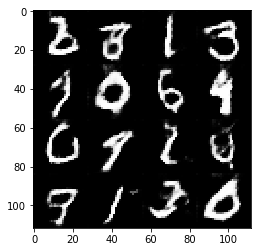

steps: 601
Global step: 1801
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.4622
steps: 602
Global step: 1804
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.5165
steps: 603
Global step: 1807
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.9069
steps: 604
Global step: 1810
Epoch 1/2... Discriminator Loss: 1.6764... Generator Loss: 0.3339
steps: 605
Global step: 1813
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 2.3672
steps: 606
Global step: 1816
Epoch 1/2... Discriminator Loss: 1.6857... Generator Loss: 0.3393
steps: 607
Global step: 1819
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 1.8363
steps: 608
Global step: 1822
Epoch 1/2... Discriminator Loss: 1.6962... Generator Loss: 0.2910
steps: 609
Global step: 1825
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 1.9958
steps: 610
Global step: 1828
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.5586
steps: 611
Global step: 1831
Epoch 1/2... Discrimi

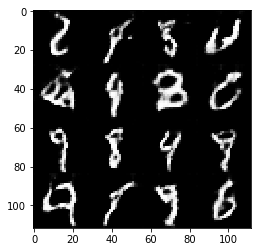

steps: 621
Global step: 1861
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.3913
steps: 622
Global step: 1864
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.5957
steps: 623
Global step: 1867
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.7116
steps: 624
Global step: 1870
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.4964
steps: 625
Global step: 1873
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 1.7868
steps: 626
Global step: 1876
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.3927
steps: 627
Global step: 1879
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 2.2908
steps: 628
Global step: 1882
Epoch 1/2... Discriminator Loss: 1.4770... Generator Loss: 0.4284
steps: 629
Global step: 1885
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.5617
steps: 630
Global step: 1888
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.6902
steps: 631
Global step: 1891
Epoch 1/2... Discrimi

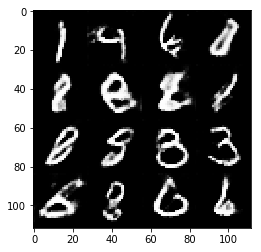

steps: 641
Global step: 1921
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.6307
steps: 642
Global step: 1924
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.3030
steps: 643
Global step: 1927
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.6245
steps: 644
Global step: 1930
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 1.1205
steps: 645
Global step: 1933
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.1442
steps: 646
Global step: 1936
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.6823
steps: 647
Global step: 1939
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 1.2491
steps: 648
Global step: 1942
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.4622
steps: 649
Global step: 1945
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 2.0526
steps: 650
Global step: 1948
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.4721
steps: 651
Global step: 1951
Epoch 1/2... Discrimi

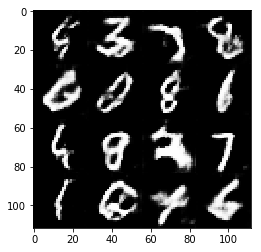

steps: 661
Global step: 1981
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.2932
steps: 662
Global step: 1984
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.5322
steps: 663
Global step: 1987
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 1.7724
steps: 664
Global step: 1990
Epoch 1/2... Discriminator Loss: 1.4764... Generator Loss: 0.3869
steps: 665
Global step: 1993
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 2.5681
steps: 666
Global step: 1996
Epoch 1/2... Discriminator Loss: 2.0933... Generator Loss: 0.1962
steps: 667
Global step: 1999
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 2.0165
steps: 668
Global step: 2002
Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.6006
steps: 669
Global step: 2005
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 1.3566
steps: 670
Global step: 2008
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.7092
steps: 671
Global step: 2011
Epoch 1/2... Discrimi

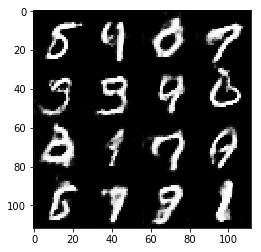

steps: 681
Global step: 2041
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 0.9614
steps: 682
Global step: 2044
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.1025
steps: 683
Global step: 2047
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.6532
steps: 684
Global step: 2050
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.9300
steps: 685
Global step: 2053
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 1.0390
steps: 686
Global step: 2056
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.8978
steps: 687
Global step: 2059
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 0.9991
steps: 688
Global step: 2062
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.7357
steps: 689
Global step: 2065
Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 0.9084
steps: 690
Global step: 2068
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.7797
steps: 691
Global step: 2071
Epoch 1/2... Discrimi

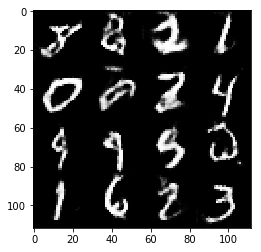

steps: 701
Global step: 2101
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.5953
steps: 702
Global step: 2104
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 1.2519
steps: 703
Global step: 2107
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.6347
steps: 704
Global step: 2110
Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 1.4636
steps: 705
Global step: 2113
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.3707
steps: 706
Global step: 2116
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 2.5418
steps: 707
Global step: 2119
Epoch 1/2... Discriminator Loss: 1.5681... Generator Loss: 0.3246
steps: 708
Global step: 2122
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.7814
steps: 709
Global step: 2125
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.8375
steps: 710
Global step: 2128
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 0.8959
steps: 711
Global step: 2131
Epoch 1/2... Discrimi

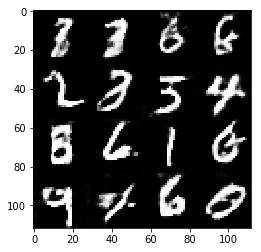

steps: 721
Global step: 2161
Epoch 1/2... Discriminator Loss: 1.7524... Generator Loss: 0.2777
steps: 722
Global step: 2164
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 2.4820
steps: 723
Global step: 2167
Epoch 1/2... Discriminator Loss: 1.9320... Generator Loss: 0.2462
steps: 724
Global step: 2170
Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 2.6634
steps: 725
Global step: 2173
Epoch 1/2... Discriminator Loss: 2.4942... Generator Loss: 0.1170
steps: 726
Global step: 2176
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 2.4003
steps: 727
Global step: 2179
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 0.7862
steps: 728
Global step: 2182
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.6362
steps: 729
Global step: 2185
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 1.2845
steps: 730
Global step: 2188
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 0.8070
steps: 731
Global step: 2191
Epoch 1/2... Discrimi

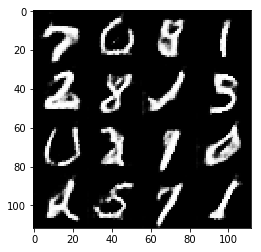

steps: 741
Global step: 2221
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.7429
steps: 742
Global step: 2224
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 1.6707
steps: 743
Global step: 2227
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.3517
steps: 744
Global step: 2230
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.6167
steps: 745
Global step: 2233
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.6067
steps: 746
Global step: 2236
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 1.2544
steps: 747
Global step: 2239
Epoch 1/2... Discriminator Loss: 1.0844... Generator Loss: 0.6692
steps: 748
Global step: 2242
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.4038
steps: 749
Global step: 2245
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 0.7887
steps: 750
Global step: 2248
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 1.1745
steps: 751
Global step: 2251
Epoch 1/2... Discrimi

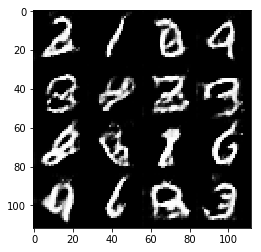

steps: 761
Global step: 2281
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 1.1373
steps: 762
Global step: 2284
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.5545
steps: 763
Global step: 2287
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.2091
steps: 764
Global step: 2290
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.6733
steps: 765
Global step: 2293
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 1.5997
steps: 766
Global step: 2296
Epoch 1/2... Discriminator Loss: 1.6423... Generator Loss: 0.3376
steps: 767
Global step: 2299
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 2.3291
steps: 768
Global step: 2302
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.4954
steps: 769
Global step: 2305
Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 1.7139
steps: 770
Global step: 2308
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.7123
steps: 771
Global step: 2311
Epoch 1/2... Discrimi

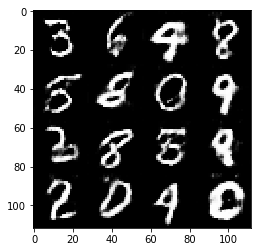

steps: 781
Global step: 2341
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.7254
steps: 782
Global step: 2344
Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 1.1011
steps: 783
Global step: 2347
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 0.9667
steps: 784
Global step: 2350
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.7148
steps: 785
Global step: 2353
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.4709
steps: 786
Global step: 2356
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.4300
steps: 787
Global step: 2359
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.8252
steps: 788
Global step: 2362
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.3900
steps: 789
Global step: 2365
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.8274
steps: 790
Global step: 2368
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.6556
steps: 791
Global step: 2371
Epoch 1/2... Discrimi

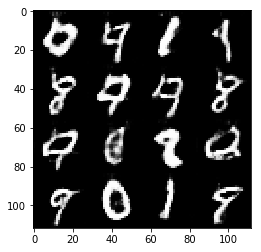

steps: 801
Global step: 2401
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.0337
steps: 802
Global step: 2404
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.6605
steps: 803
Global step: 2407
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.3047
steps: 804
Global step: 2410
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.6447
steps: 805
Global step: 2413
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 1.0575
steps: 806
Global step: 2416
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.4153
steps: 807
Global step: 2419
Epoch 1/2... Discriminator Loss: 1.9864... Generator Loss: 3.1387
steps: 808
Global step: 2422
Epoch 1/2... Discriminator Loss: 1.9165... Generator Loss: 0.2320
steps: 809
Global step: 2425
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 2.2753
steps: 810
Global step: 2428
Epoch 1/2... Discriminator Loss: 1.6504... Generator Loss: 0.2899
steps: 811
Global step: 2431
Epoch 1/2... Discrimi

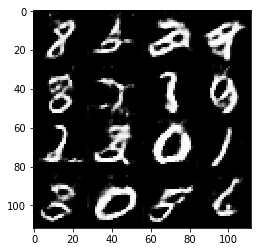

steps: 821
Global step: 2461
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.6393
steps: 822
Global step: 2464
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.0497
steps: 823
Global step: 2467
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.7454
steps: 824
Global step: 2470
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.9256
steps: 825
Global step: 2473
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.7993
steps: 826
Global step: 2476
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 0.9746
steps: 827
Global step: 2479
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 0.9171
steps: 828
Global step: 2482
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 0.7530
steps: 829
Global step: 2485
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.1084
steps: 830
Global step: 2488
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.6928
steps: 831
Global step: 2491
Epoch 1/2... Discrimi

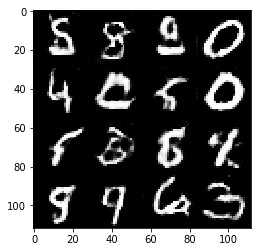

steps: 841
Global step: 2521
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 2.0494
steps: 842
Global step: 2524
Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.4230
steps: 843
Global step: 2527
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.5547
steps: 844
Global step: 2530
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.6193
steps: 845
Global step: 2533
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.1108
steps: 846
Global step: 2536
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.7738
steps: 847
Global step: 2539
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.0685
steps: 848
Global step: 2542
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.5481
steps: 849
Global step: 2545
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.0857
steps: 850
Global step: 2548
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.7103
steps: 851
Global step: 2551
Epoch 1/2... Discrimi

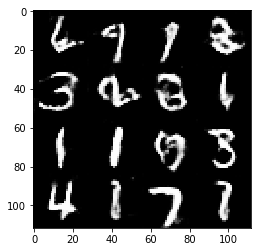

steps: 861
Global step: 2581
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.6220
steps: 862
Global step: 2584
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.6503
steps: 863
Global step: 2587
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.1897
steps: 864
Global step: 2590
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.6012
steps: 865
Global step: 2593
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.2610
steps: 866
Global step: 2596
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.5194
steps: 867
Global step: 2599
Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 0.7983
steps: 868
Global step: 2602
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.3141
steps: 869
Global step: 2605
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.5248
steps: 870
Global step: 2608
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.7095
steps: 871
Global step: 2611
Epoch 1/2... Discrimi

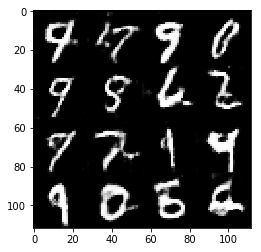

steps: 881
Global step: 2641
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 1.1169
steps: 882
Global step: 2644
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.5772
steps: 883
Global step: 2647
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 1.1941
steps: 884
Global step: 2650
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.7299
steps: 885
Global step: 2653
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.3492
steps: 886
Global step: 2656
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.5706
steps: 887
Global step: 2659
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.6558
steps: 888
Global step: 2662
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 0.5019
steps: 889
Global step: 2665
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 1.0931
steps: 890
Global step: 2668
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.0095
steps: 891
Global step: 2671
Epoch 1/2... Discrimi

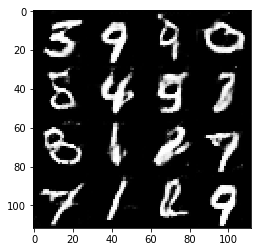

steps: 901
Global step: 2701
Epoch 1/2... Discriminator Loss: 1.7660... Generator Loss: 0.2899
steps: 902
Global step: 2704
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 1.9109
steps: 903
Global step: 2707
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.5515
steps: 904
Global step: 2710
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.2255
steps: 905
Global step: 2713
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.5695
steps: 906
Global step: 2716
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 1.6557
steps: 907
Global step: 2719
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.3560
steps: 908
Global step: 2722
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 2.1262
steps: 909
Global step: 2725
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.4242
steps: 910
Global step: 2728
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.2012
steps: 911
Global step: 2731
Epoch 1/2... Discrimi

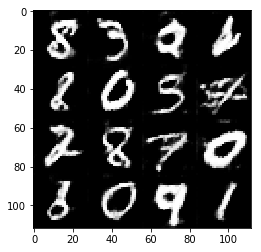

steps: 921
Global step: 2761
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.0406
steps: 922
Global step: 2764
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.7513
steps: 923
Global step: 2767
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.0456
steps: 924
Global step: 2770
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.5838
steps: 925
Global step: 2773
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 1.4189
steps: 926
Global step: 2776
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.3674
steps: 927
Global step: 2779
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.6701
steps: 928
Global step: 2782
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.4740
steps: 929
Global step: 2785
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.6192
steps: 930
Global step: 2788
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.6681
steps: 931
Global step: 2791
Epoch 1/2... Discrimi

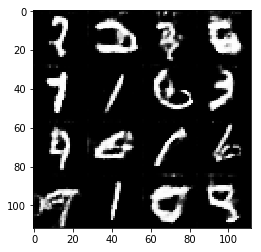

steps: 941
Global step: 2821
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 2.0130
steps: 942
Global step: 2824
Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.4792
steps: 943
Global step: 2827
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.3294
steps: 944
Global step: 2830
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.5582
steps: 945
Global step: 2833
Epoch 2/2... Discriminator Loss: 0.9283... Generator Loss: 1.1265
steps: 946
Global step: 2836
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.2362
steps: 947
Global step: 2839
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.4256
steps: 948
Global step: 2842
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 1.8561
steps: 949
Global step: 2845
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 0.6736
steps: 950
Global step: 2848
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.3817
steps: 951
Global step: 2851
Epoch 2/2... Discrimi

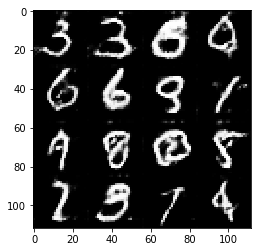

steps: 961
Global step: 2881
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 0.8300
steps: 962
Global step: 2884
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.8682
steps: 963
Global step: 2887
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 0.8487
steps: 964
Global step: 2890
Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 0.7376
steps: 965
Global step: 2893
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.0507
steps: 966
Global step: 2896
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 0.6165
steps: 967
Global step: 2899
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.6185
steps: 968
Global step: 2902
Epoch 2/2... Discriminator Loss: 1.6411... Generator Loss: 0.3059
steps: 969
Global step: 2905
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 2.1239
steps: 970
Global step: 2908
Epoch 2/2... Discriminator Loss: 1.7105... Generator Loss: 0.3302
steps: 971
Global step: 2911
Epoch 2/2... Discrimi

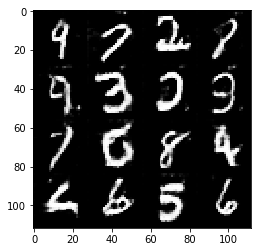

steps: 981
Global step: 2941
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.5778
steps: 982
Global step: 2944
Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.3309
steps: 983
Global step: 2947
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.3562
steps: 984
Global step: 2950
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 0.5820
steps: 985
Global step: 2953
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.0829
steps: 986
Global step: 2956
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.7530
steps: 987
Global step: 2959
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 0.8930
steps: 988
Global step: 2962
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 0.9106
steps: 989
Global step: 2965
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 0.7168
steps: 990
Global step: 2968
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.0494
steps: 991
Global step: 2971
Epoch 2/2... Discrimi

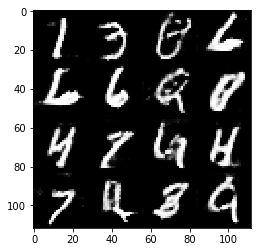

steps: 1001
Global step: 3001
Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 1.8894
steps: 1002
Global step: 3004
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.3897
steps: 1003
Global step: 3007
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 1.4380
steps: 1004
Global step: 3010
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 0.8095
steps: 1005
Global step: 3013
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 0.8072
steps: 1006
Global step: 3016
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.5596
steps: 1007
Global step: 3019
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 1.3728
steps: 1008
Global step: 3022
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 0.7547
steps: 1009
Global step: 3025
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 1.0498
steps: 1010
Global step: 3028
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.6660
steps: 1011
Global step: 3031
Epoch 2/2.

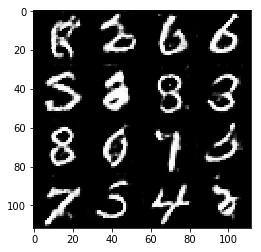

steps: 1021
Global step: 3061
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 0.9073
steps: 1022
Global step: 3064
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.7040
steps: 1023
Global step: 3067
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.0236
steps: 1024
Global step: 3070
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 0.6076
steps: 1025
Global step: 3073
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 1.8570
steps: 1026
Global step: 3076
Epoch 2/2... Discriminator Loss: 1.7662... Generator Loss: 0.2477
steps: 1027
Global step: 3079
Epoch 2/2... Discriminator Loss: 1.4638... Generator Loss: 2.5367
steps: 1028
Global step: 3082
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.5511
steps: 1029
Global step: 3085
Epoch 2/2... Discriminator Loss: 1.0907... Generator Loss: 0.7410
steps: 1030
Global step: 3088
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 1.5032
steps: 1031
Global step: 3091
Epoch 2/2.

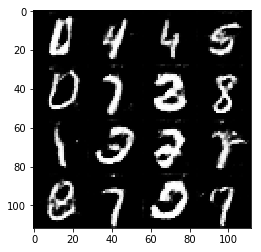

steps: 1041
Global step: 3121
Epoch 2/2... Discriminator Loss: 1.6434... Generator Loss: 3.0027
steps: 1042
Global step: 3124
Epoch 2/2... Discriminator Loss: 1.5189... Generator Loss: 0.3669
steps: 1043
Global step: 3127
Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 2.0355
steps: 1044
Global step: 3130
Epoch 2/2... Discriminator Loss: 1.2405... Generator Loss: 0.4795
steps: 1045
Global step: 3133
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.2428
steps: 1046
Global step: 3136
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.0581
steps: 1047
Global step: 3139
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.6083
steps: 1048
Global step: 3142
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.1288
steps: 1049
Global step: 3145
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.6489
steps: 1050
Global step: 3148
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.8037
steps: 1051
Global step: 3151
Epoch 2/2.

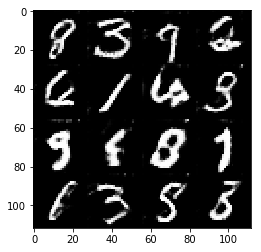

steps: 1061
Global step: 3181
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.3147
steps: 1062
Global step: 3184
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.6200
steps: 1063
Global step: 3187
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 0.9644
steps: 1064
Global step: 3190
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 0.9048
steps: 1065
Global step: 3193
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 0.8724
steps: 1066
Global step: 3196
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.6024
steps: 1067
Global step: 3199
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 1.6448
steps: 1068
Global step: 3202
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.4480
steps: 1069
Global step: 3205
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 1.2314
steps: 1070
Global step: 3208
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.9026
steps: 1071
Global step: 3211
Epoch 2/2.

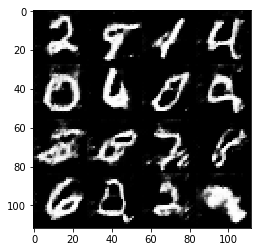

steps: 1081
Global step: 3241
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 0.8236
steps: 1082
Global step: 3244
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 1.0524
steps: 1083
Global step: 3247
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.6208
steps: 1084
Global step: 3250
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 1.4387
steps: 1085
Global step: 3253
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.5121
steps: 1086
Global step: 3256
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 2.1049
steps: 1087
Global step: 3259
Epoch 2/2... Discriminator Loss: 1.7994... Generator Loss: 0.2653
steps: 1088
Global step: 3262
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 2.0736
steps: 1089
Global step: 3265
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.5912
steps: 1090
Global step: 3268
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 1.0250
steps: 1091
Global step: 3271
Epoch 2/2.

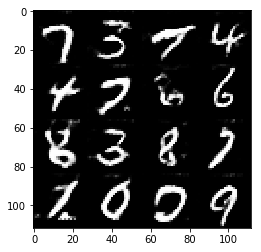

steps: 1101
Global step: 3301
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 0.9524
steps: 1102
Global step: 3304
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.8046
steps: 1103
Global step: 3307
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 0.9361
steps: 1104
Global step: 3310
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 0.9663
steps: 1105
Global step: 3313
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.6473
steps: 1106
Global step: 3316
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 1.0889
steps: 1107
Global step: 3319
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.4683
steps: 1108
Global step: 3322
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 1.7511
steps: 1109
Global step: 3325
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 0.5861
steps: 1110
Global step: 3328
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.1990
steps: 1111
Global step: 3331
Epoch 2/2.

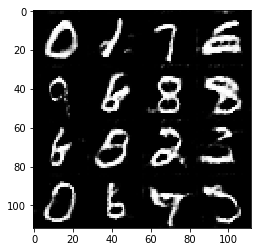

steps: 1121
Global step: 3361
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 1.0378
steps: 1122
Global step: 3364
Epoch 2/2... Discriminator Loss: 1.0568... Generator Loss: 0.7749
steps: 1123
Global step: 3367
Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 1.0058
steps: 1124
Global step: 3370
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 0.6543
steps: 1125
Global step: 3373
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.4070
steps: 1126
Global step: 3376
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 0.5610
steps: 1127
Global step: 3379
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 1.6441
steps: 1128
Global step: 3382
Epoch 2/2... Discriminator Loss: 1.7037... Generator Loss: 0.2844
steps: 1129
Global step: 3385
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.7542
steps: 1130
Global step: 3388
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.4579
steps: 1131
Global step: 3391
Epoch 2/2.

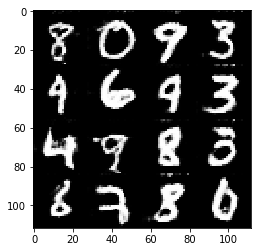

steps: 1141
Global step: 3421
Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 0.8098
steps: 1142
Global step: 3424
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.7018
steps: 1143
Global step: 3427
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.1181
steps: 1144
Global step: 3430
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.7538
steps: 1145
Global step: 3433
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.5951
steps: 1146
Global step: 3436
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 2.1732
steps: 1147
Global step: 3439
Epoch 2/2... Discriminator Loss: 1.6166... Generator Loss: 0.3377
steps: 1148
Global step: 3442
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 2.3088
steps: 1149
Global step: 3445
Epoch 2/2... Discriminator Loss: 1.7281... Generator Loss: 0.3115
steps: 1150
Global step: 3448
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 1.0981
steps: 1151
Global step: 3451
Epoch 2/2.

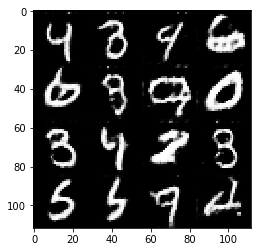

steps: 1161
Global step: 3481
Epoch 2/2... Discriminator Loss: 1.7151... Generator Loss: 0.2859
steps: 1162
Global step: 3484
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.5136
steps: 1163
Global step: 3487
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 0.7495
steps: 1164
Global step: 3490
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.5755
steps: 1165
Global step: 3493
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.2604
steps: 1166
Global step: 3496
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.6622
steps: 1167
Global step: 3499
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.0585
steps: 1168
Global step: 3502
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 0.7644
steps: 1169
Global step: 3505
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.7292
steps: 1170
Global step: 3508
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 0.9506
steps: 1171
Global step: 3511
Epoch 2/2.

KeyboardInterrupt: 

In [55]:
batch_size = 64
z_dim = 30
learning_rate = 0.001
beta1 = 0.4
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
# batch_size = 64
# z_dim = 100
# learning_rate = 0.001
# beta1 = 0.4
# tf.reset_default_graph()


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# epochs = 1

# celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
# with tf.Graph().as_default():
#     train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
#           celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.